In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_config

In [3]:
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot,
    perform_kernel_pca_and_plot,
    perform_pca_and_plot_3d
)

In [4]:
config       = load_config()
features_dir = config['data_paths']['features']
features_csv = os.path.join(features_dir, 'all_features.csv')

In [ ]:
features_df = pd.read_csv(features_csv)
features_df

## Feature Selection Methods

Feature selection is a crucial step in the machine learning pipeline. It helps in reducing dimensionality, removing redundant data, improving learning accuracy, and reducing training time. There are three main types of feature selection methods:

### 1. Filter Methods
Filter methods evaluate the relevance of features based on their intrinsic statistical properties and their relationship with the target variable, independently of the model used later. Common filter methods include:
- **Correlation Coefficient**: Measures the linear relationship between two variables.
- **Chi-Squared Test**: Evaluates the independence of two categorical variables.
- **ANOVA F-test**: Analyzes variance among group means in a sample.

### 2. Wrapper Methods
Wrapper methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated, and compared to other combinations. A predictive model is used to assess the combination of features and assign a score based on model accuracy.
- **Recursive Feature Elimination (RFE)**: Recursively removes attributes and builds a model on those attributes that remain.

### 3. Embedded Methods
Embedded methods integrate the feature selection process during the model training and are specific to given learning algorithms. These methods combine qualities of filter and wrapper methods.
- **Random Forest Importance**: Uses the Random Forests algorithm to rank the importance of features based on how much they improve the purity of the node.

In [6]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

def select_features(features_df, target_column='real_or_fake', method='random_forest', k=10):
    """
    Selects the top `k` important features based on a specified method and sorts them by importance.

    Parameters:
    - features_df (DataFrame): The DataFrame containing the features and target.
    - target_column (str): The name of the target column.
    - method (str): The method for feature selection ('anova', 'mutual_info', 'chi2', 'rfe', or 'random_forest').
    - k (int): The number of features to select.

    Returns:
    - selected_features (Series/Index): An index of selected feature names sorted by importance.
    """
    if method not in ['anova', 'mutual_info', 'chi2', 'rfe', 'random_forest']:
        raise ValueError("Method must be one of 'anova', 'mutual_info', 'chi2', 'rfe', or 'random_forest'")

    X = features_df.drop(columns=['audio_id', target_column])
    y = features_df[target_column]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)

    if method == 'anova':
        selector = SelectKBest(f_classif, k=k)
    elif method == 'mutual_info':
        selector = SelectKBest(mutual_info_classif, k=k)
    elif method == 'chi2':
        # Ensure all data is non-negative since Chi-squared requires this
        X = np.maximum(X, 0)
        selector = SelectKBest(chi2, k=k)
    elif method == 'rfe':
        model = RandomForestClassifier(random_state=42)
        selector = RFE(model, n_features_to_select=k)
    else:
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
        feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
        return feature_importances.head(k).index

    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    if method in ['anova', 'mutual_info', 'chi2']:
        importances = pd.Series(selector.scores_, index=X.columns)
        selected_features = importances.sort_values(ascending=False).head(k).index

    return selected_features


### F01 vs R

In [8]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'F01'])].reset_index()

In [9]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_std', 'spectral_contrast_var',
       'spectral_contrast_max', 'spectral_contrast_range',
       'spectral_contrast_mean', 'spectral_contrast_skew',
       'spectral_contrast_75th_percentile', 'spectral_contrast_kurtosis',
       'spectral_contrast_50th_percentile', 'spectral_bandwidth_min'],
      dtype='object')

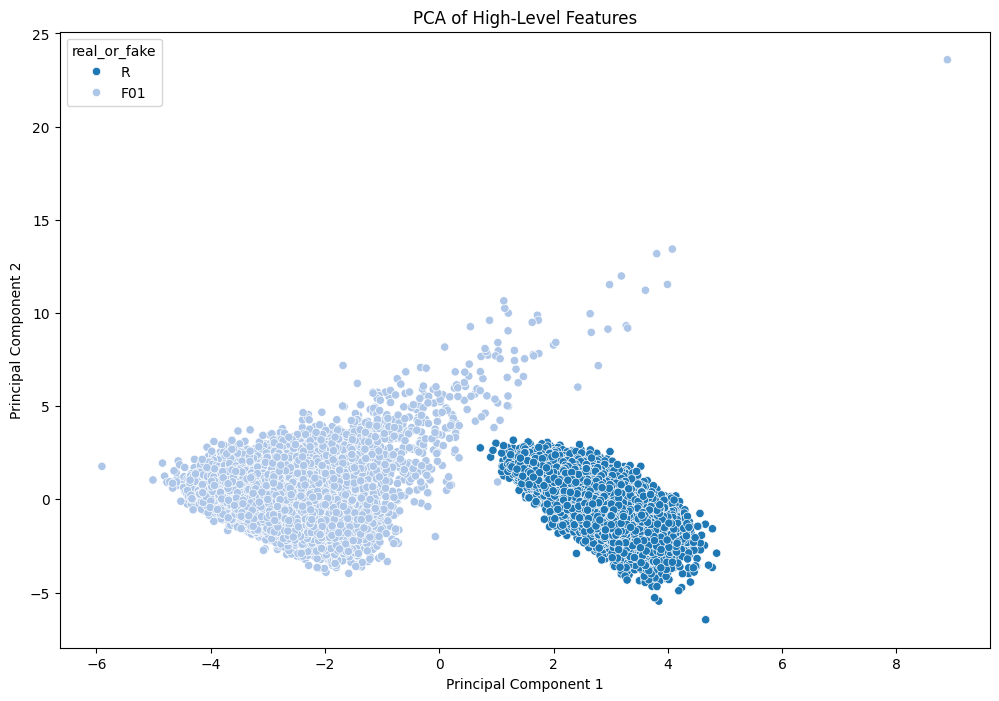

In [10]:
perform_pca_and_plot(f_df, selected_features)

### F02 vs R

In [14]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'F02'])].reset_index()

In [15]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_std', 'spectral_contrast_var',
       'spectral_contrast_mean', 'spectral_contrast_max',
       'spectral_contrast_range', 'spectral_contrast_skew',
       'spectral_contrast_75th_percentile',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_25th_percentile', 'spectral_flatness_max'],
      dtype='object')

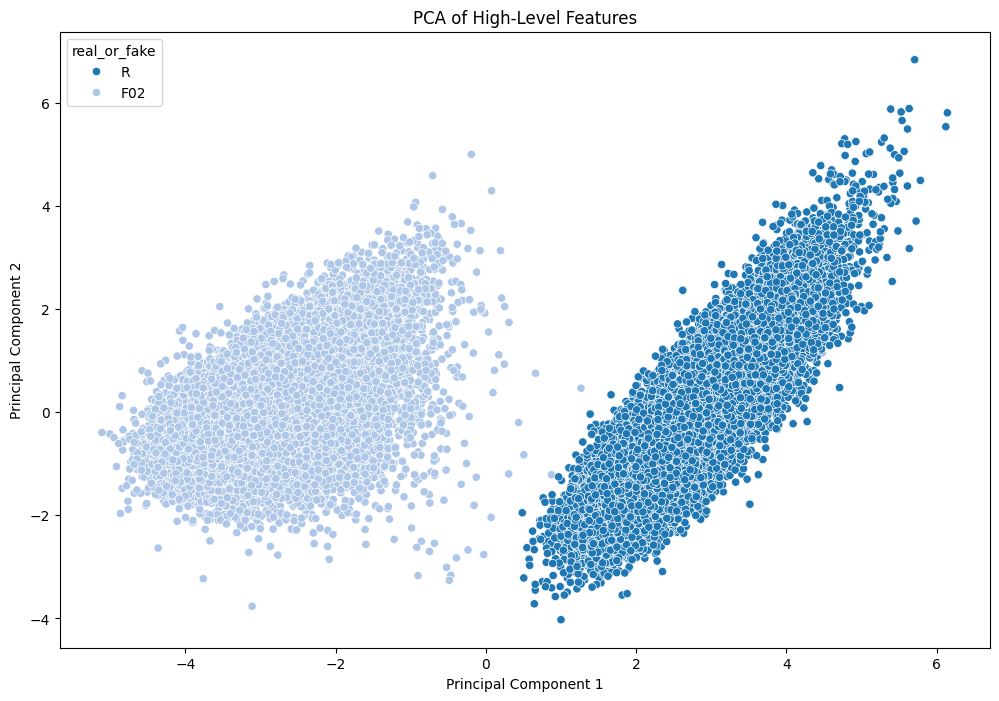

In [16]:
perform_pca_and_plot(f_df, selected_features)

### F03 vs R

In [17]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'F03'])].reset_index()

In [18]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_var', 'spectral_contrast_std',
       'spectral_contrast_max', 'spectral_contrast_range',
       'spectral_contrast_mean', 'spectral_contrast_skew', 'spectral_flux_std',
       'energy_std', 'energy_max', 'energy_range'],
      dtype='object')

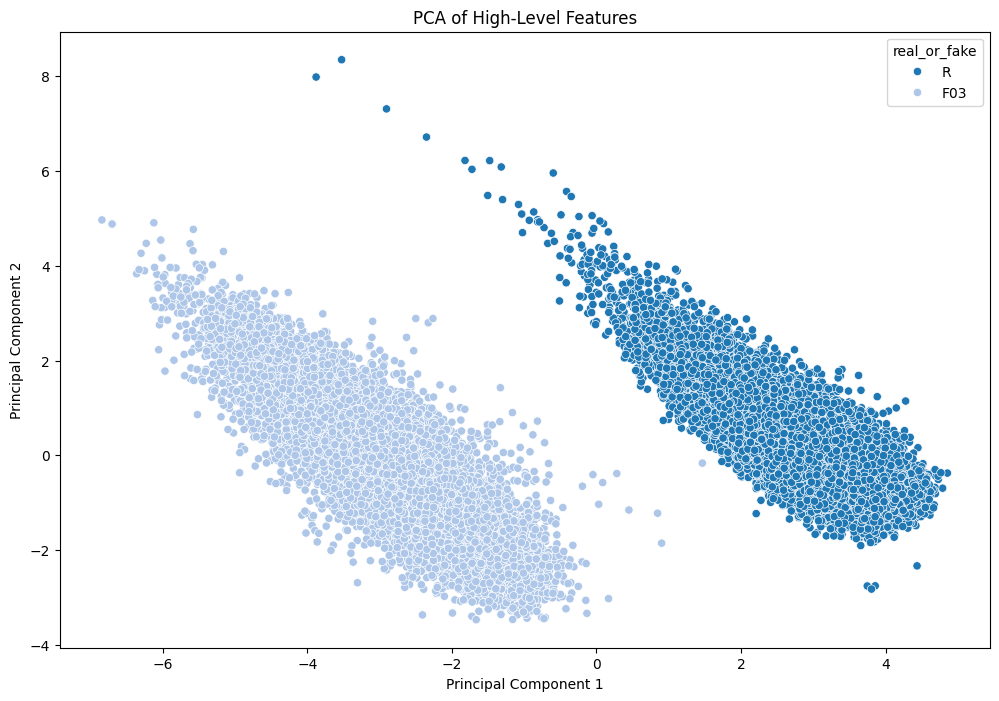

In [19]:
perform_pca_and_plot(f_df, selected_features)

### F04 vs R

In [20]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'F04'])].reset_index()

In [21]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_var', 'spectral_contrast_std',
       'spectral_contrast_kurtosis', 'shimmer_dda', 'shimmer_apq3',
       'spectral_contrast_skew', 'shimmer_apq5',
       'spectral_bandwidth_25th_percentile', 'shimmer_local',
       'spectral_contrast_75th_percentile'],
      dtype='object')

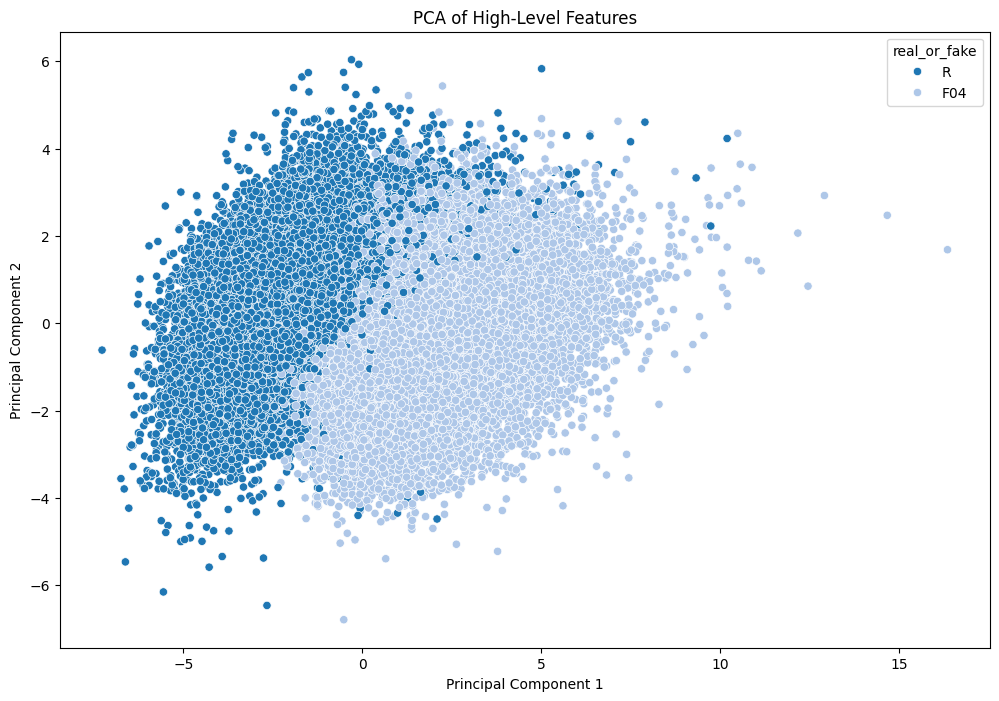

In [22]:
perform_pca_and_plot(f_df, selected_features)

### F05 vs R

In [23]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'F05'])].reset_index()

In [26]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_75th_percentile',
       'spectral_contrast_skew', 'spectral_contrast_50th_percentile',
       'spectral_contrast_25th_percentile', 'spectral_contrast_kurtosis',
       'spectral_contrast_max', 'jitter_ppq5', 'jitter_rap',
       'spectral_contrast_range'],
      dtype='object')

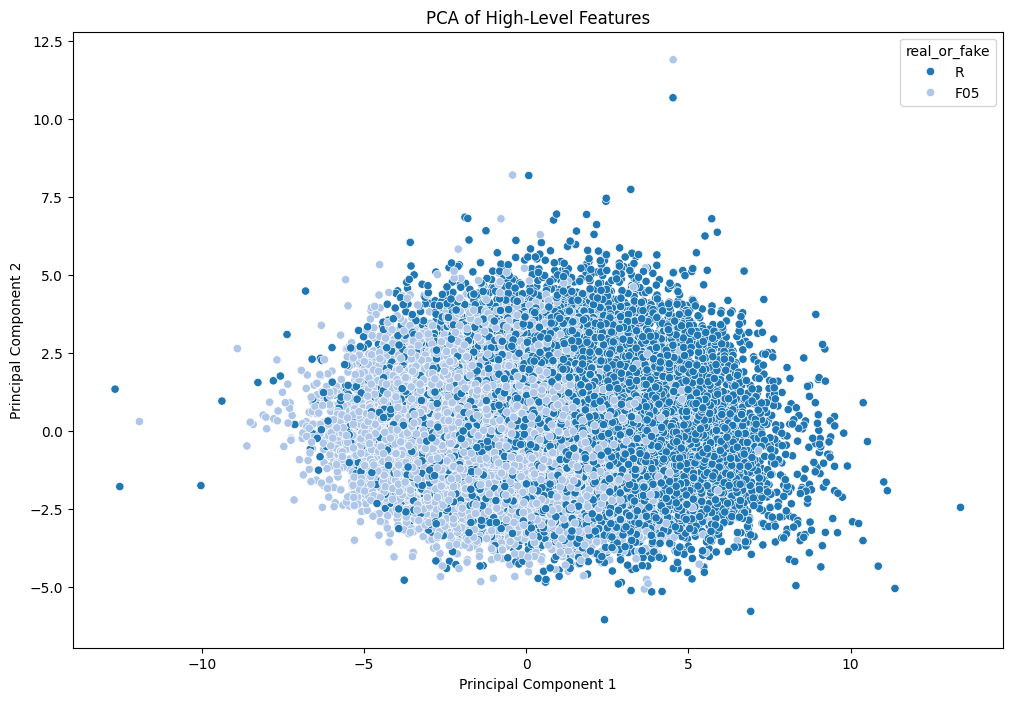

In [27]:
perform_pca_and_plot(f_df, selected_features)

### F06 vs R

In [28]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'F06'])].reset_index()

In [29]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_var', 'spectral_contrast_std',
       'spectral_contrast_max', 'spectral_contrast_range',
       'spectral_contrast_mean', 'spectral_contrast_skew', 'spectral_flux_std',
       'energy_std', 'energy_max', 'energy_range'],
      dtype='object')

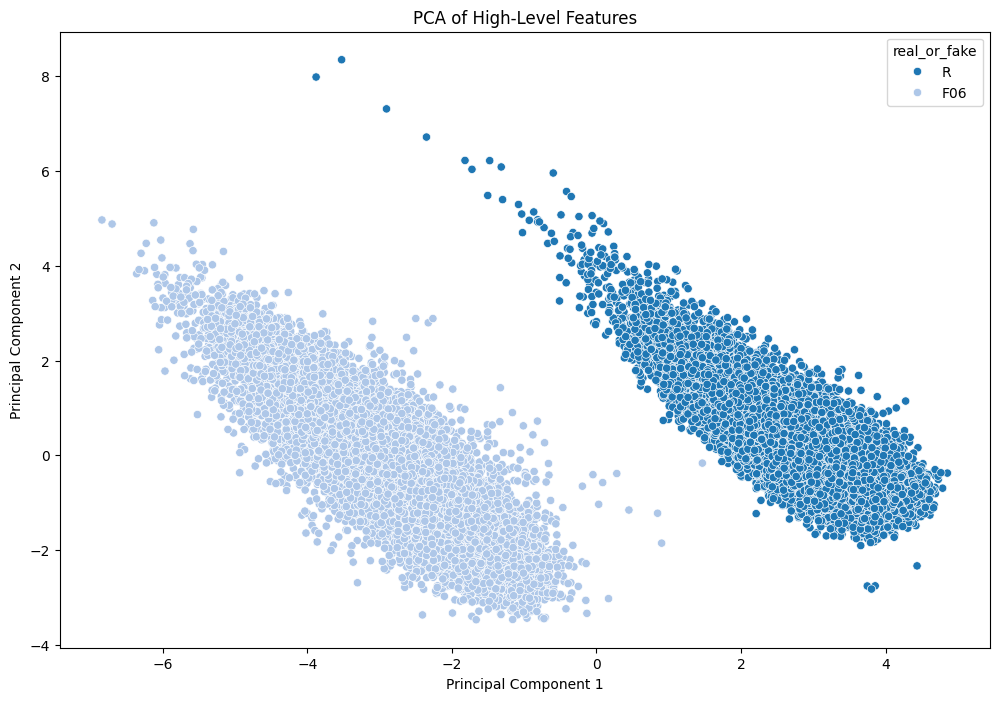

In [30]:
perform_pca_and_plot(f_df, selected_features)

### WF1 vs R

In [33]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF1'])].reset_index()

In [34]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['shimmer_local', 'spectral_contrast_range', 'jitter_ppq5',
       'spectral_contrast_max', 'articulationrate',
       'spectral_contrast_75th_percentile', 'speakingrate',
       'spectral_contrast_mean', 'spectral_contrast_50th_percentile', 'asd'],
      dtype='object')

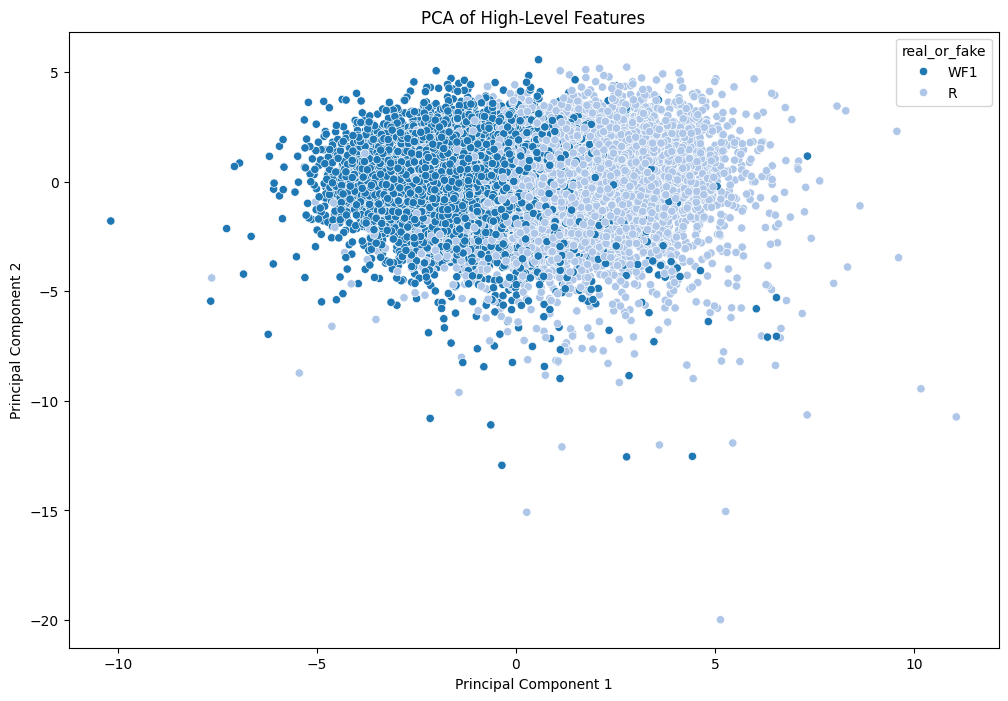

In [35]:
perform_pca_and_plot(f_df, selected_features)

### WF2 vs R

In [36]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF2'])].reset_index()

In [40]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_mean', 'spectral_contrast_75th_percentile',
       'spectral_contrast_skew', 'spectral_contrast_kurtosis',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_25th_percentile', 'jitter_ppq5', 'jitter_rap',
       'spectral_flatness_mean', 'spectral_flatness_std'],
      dtype='object')

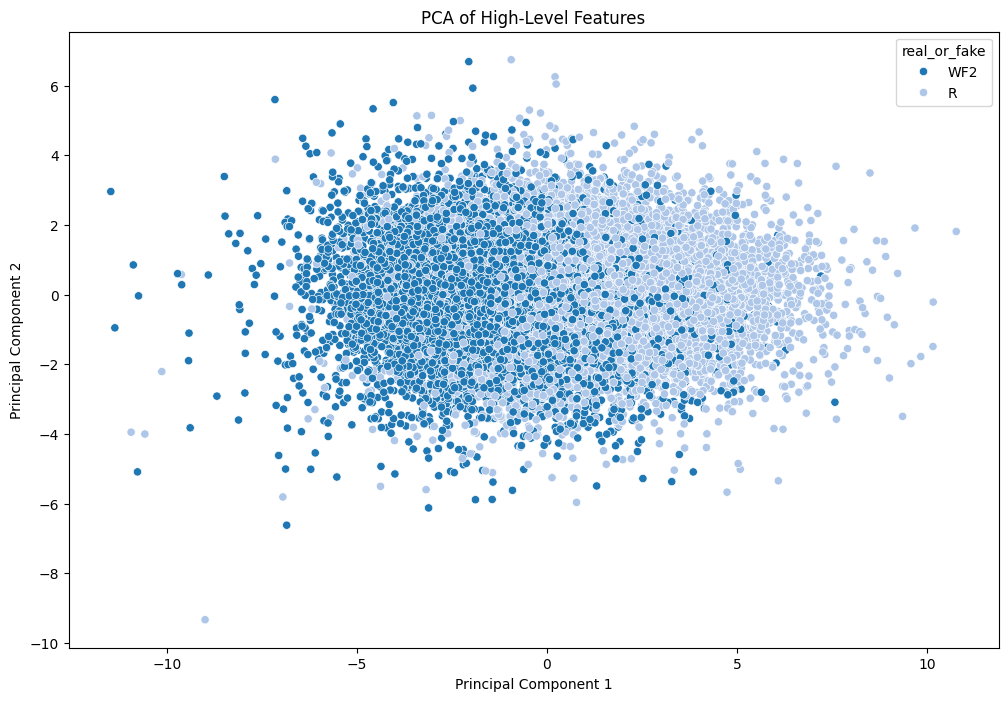

In [41]:
perform_pca_and_plot(f_df, selected_features)

### WF3 vs R

In [42]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF3'])].reset_index()

In [43]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_skew', 'spectral_contrast_kurtosis',
       'spectral_contrast_75th_percentile', 'spectral_contrast_mean',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_25th_percentile', 'jitter_ppq5', 'shimmer_dda',
       'shimmer_apq3', 'jitter_rap'],
      dtype='object')

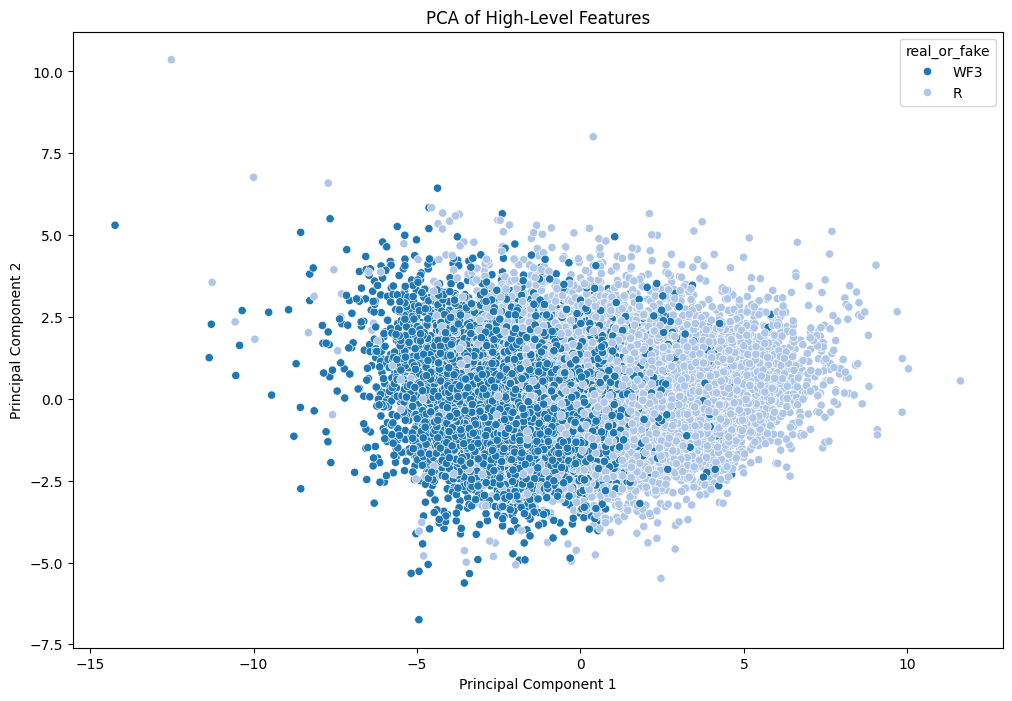

In [45]:
perform_pca_and_plot(f_df, selected_features)

### WF4 vs R

In [46]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF4'])].reset_index()

In [47]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [280 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['articulationrate', 'speakingrate', 'asd', 'spectral_contrast_var',
       'spectral_contrast_std', 'spectral_contrast_range',
       'spectral_contrast_max', 'shimmer_apq3', 'shimmer_dda',
       'spectral_contrast_25th_percentile'],
      dtype='object')

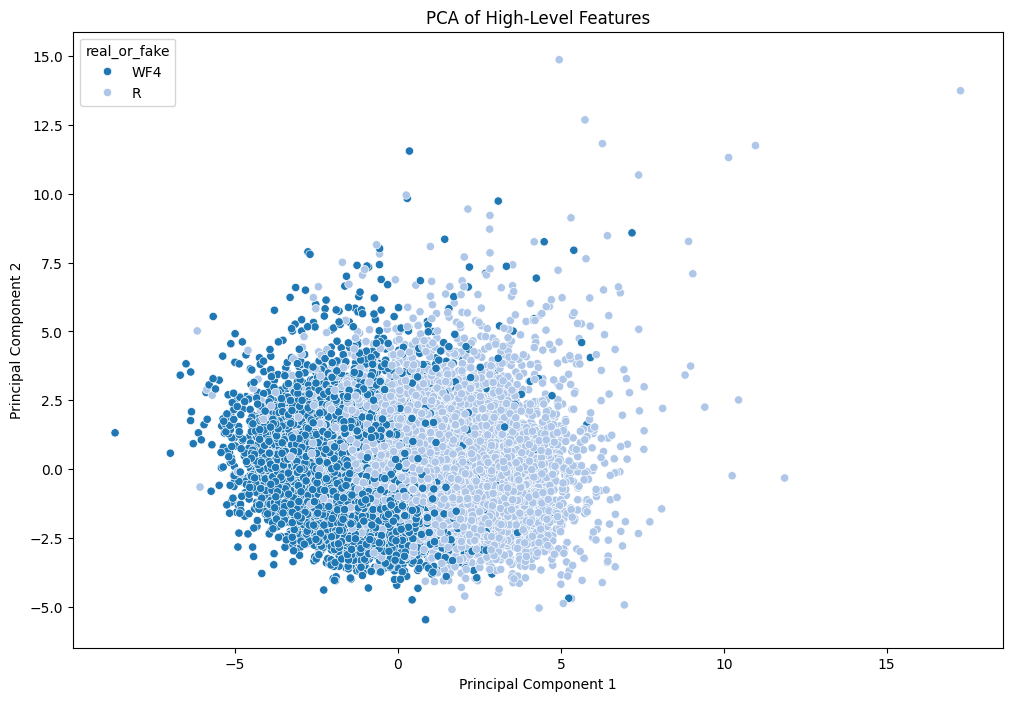

In [49]:
perform_pca_and_plot(f_df, selected_features)

### WF5 vs R

In [50]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF5'])].reset_index()

In [51]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_mean', 'spectral_contrast_kurtosis',
       'spectral_contrast_50th_percentile', 'jitter_rap', 'jitter_ppq5',
       'spectral_contrast_25th_percentile', 'hnr', 'mfcc_6_75th_percentile'],
      dtype='object')

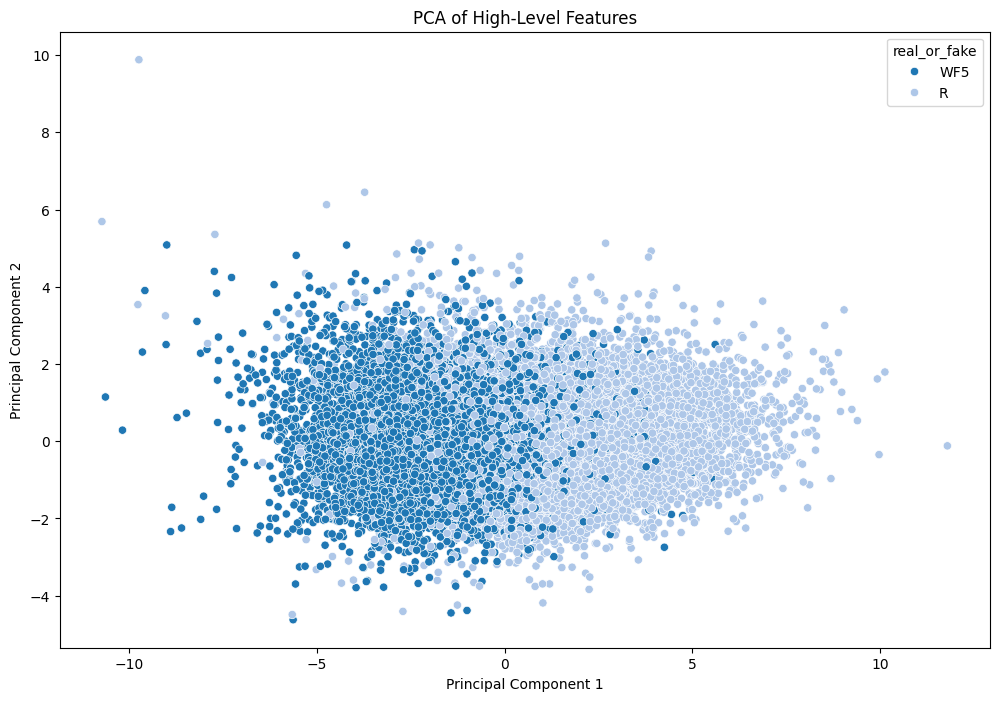

In [52]:
perform_pca_and_plot(f_df, selected_features)

### WF6 vs R

In [53]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF6'])].reset_index()

In [54]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_75th_percentile', 'spectral_contrast_skew',
       'spectral_contrast_kurtosis', 'spectral_contrast_mean',
       'spectral_contrast_50th_percentile', 'jitter_ppq5', 'jitter_rap',
       'energy_mean', 'spectral_flux_mean', 'energy_75th_percentile'],
      dtype='object')

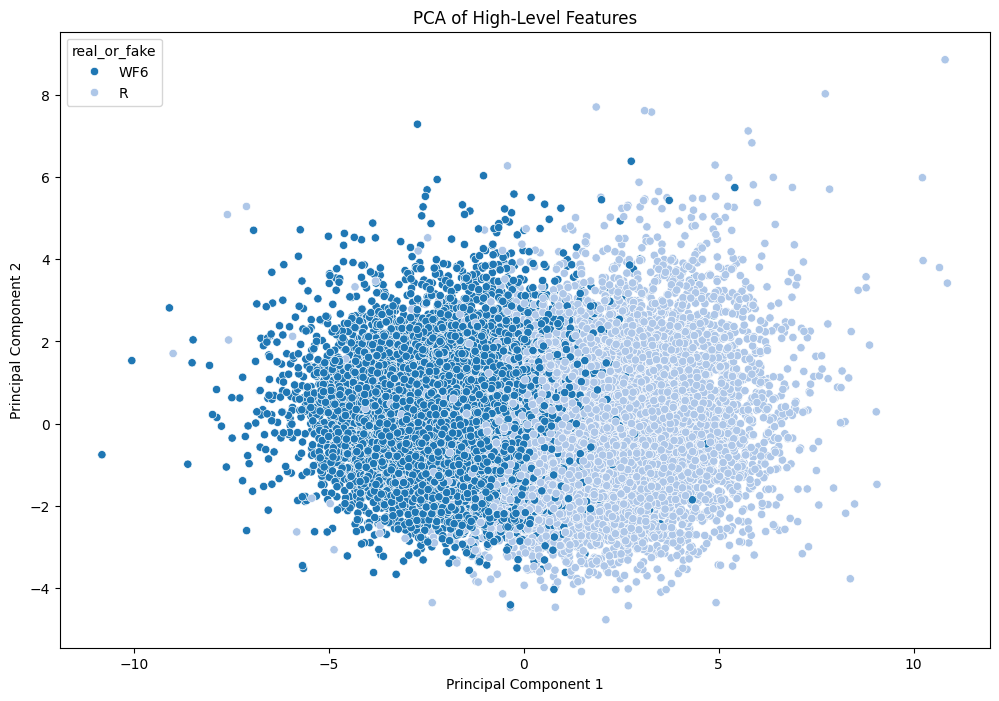

In [55]:
perform_pca_and_plot(f_df, selected_features)

### WF7 vs R

In [56]:
f_df = features_df[features_df['real_or_fake'].isin(['R', 'WF7'])].reset_index()

In [57]:
selected_features = select_features(f_df, method='anova', k=10)
selected_features

/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [225 356] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['spectral_contrast_75th_percentile', 'spectral_contrast_mean',
       'spectral_contrast_skew', 'spectral_contrast_kurtosis',
       'spectral_contrast_50th_percentile',
       'spectral_contrast_25th_percentile', 'shimmer_apq5', 'shimmer_local',
       'shimmer_dda', 'shimmer_apq3'],
      dtype='object')

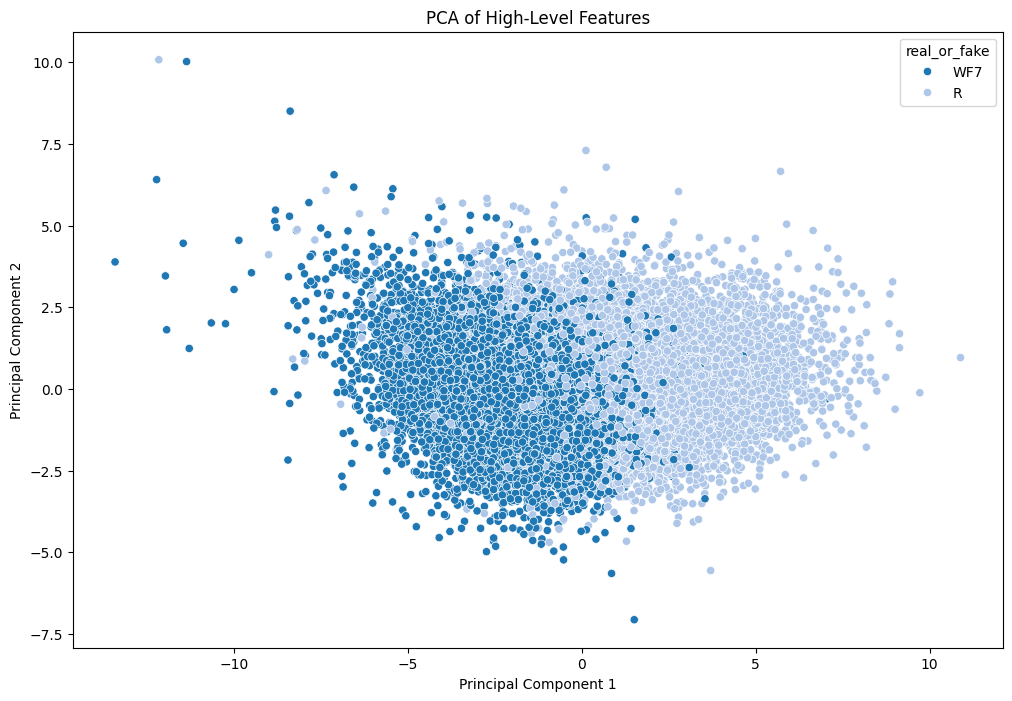

In [58]:
perform_pca_and_plot(f_df, selected_features)